## Task 1. 
Reproduce the vanilla GAN and DCGAN results on MNIST and CIFAR. 

Get the training and test loss for the generator and discriminator over time, plot them, and interpret them.

## On MINIST data,
### The optimizers used are:
        d_optimizer = optim.Adam(discriminator.parameters(), lr=0.0002)
        g_optimizer = optim.Adam(generator.parameters(), lr=0.0002)

### loss function:
        loss = nn.BCELoss()

## On CIFAR data,
### The optimizers used are:
        d_optimizer = optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))
        g_optimizer = optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
        
### loss function:
        loss = nn.BCELoss()


In [1]:
import os
import numpy as np
import errno
import torchvision.utils as vutils
from tensorboardX import SummaryWriter
from IPython import display
from matplotlib import pyplot as plt
import torch

'''
    TensorBoard Data will be stored in './runs' path
'''

class Logger:

    def __init__(self, model_name, data_name):
        self.model_name = model_name
        self.data_name = data_name

        self.comment = '{}_{}'.format(model_name, data_name)
        self.data_subdir = '{}/{}'.format(model_name, data_name)

        # TensorBoard
        self.writer = SummaryWriter(comment=self.comment)

    def log(self, d_error, g_error, epoch, n_batch, num_batches):

        # var_class = torch.autograd.variable.Variable
        if isinstance(d_error, torch.autograd.Variable):
            d_error = d_error.data.cpu().numpy()
        if isinstance(g_error, torch.autograd.Variable):
            g_error = g_error.data.cpu().numpy()

        step = Logger._step(epoch, n_batch, num_batches)
        self.writer.add_scalar(
            '{}/D_error'.format(self.comment), d_error, step)
        self.writer.add_scalar(
            '{}/G_error'.format(self.comment), g_error, step)

    def log_images(self, images, num_images, epoch, n_batch, num_batches, format='NCHW', normalize=True):
        '''
        input images are expected in format (NCHW)
        '''
        if type(images) == np.ndarray:
            images = torch.from_numpy(images)
        
        if format=='NHWC':
            images = images.transpose(1,3)
        

        step = Logger._step(epoch, n_batch, num_batches)
        img_name = '{}/images{}'.format(self.comment, '')

        # Make horizontal grid from image tensor
        horizontal_grid = vutils.make_grid(
            images, normalize=normalize, scale_each=True)
        # Make vertical grid from image tensor
        nrows = int(np.sqrt(num_images))
        grid = vutils.make_grid(
            images, nrow=nrows, normalize=True, scale_each=True)

        # Add horizontal images to tensorboard
        self.writer.add_image(img_name, horizontal_grid, step)

        # Save plots
        self.save_torch_images(horizontal_grid, grid, epoch, n_batch)

    def save_torch_images(self, horizontal_grid, grid, epoch, n_batch, plot_horizontal=True):
        out_dir = './data/images/{}'.format(self.data_subdir)
        Logger._make_dir(out_dir)

        # Plot and save horizontal
        fig = plt.figure(figsize=(16, 16))
        plt.imshow(np.moveaxis(horizontal_grid.numpy(), 0, -1))
        plt.axis('off')
        if plot_horizontal:
            display.display(plt.gcf())
        self._save_images(fig, epoch, n_batch, 'hori')
        plt.close()

        # Save squared
        fig = plt.figure()
        plt.imshow(np.moveaxis(grid.numpy(), 0, -1))
        plt.axis('off')
        self._save_images(fig, epoch, n_batch)
        plt.close()

    def _save_images(self, fig, epoch, n_batch, comment=''):
        out_dir = './data/images/{}'.format(self.data_subdir)
        Logger._make_dir(out_dir)
        fig.savefig('{}/{}_epoch_{}_batch_{}.png'.format(out_dir,
                                                         comment, epoch, n_batch))

    def display_status(self, epoch, num_epochs, n_batch, num_batches, d_error, g_error, d_pred_real, d_pred_fake):
        
        # var_class = torch.autograd.variable.Variable
        if isinstance(d_error, torch.autograd.Variable):
            d_error = d_error.data.cpu().numpy()
        if isinstance(g_error, torch.autograd.Variable):
            g_error = g_error.data.cpu().numpy()
        if isinstance(d_pred_real, torch.autograd.Variable):
            d_pred_real = d_pred_real.data
        if isinstance(d_pred_fake, torch.autograd.Variable):
            d_pred_fake = d_pred_fake.data
        
        
        print('Epoch: [{}/{}], Batch Num: [{}/{}]'.format(
            epoch,num_epochs, n_batch, num_batches)
             )
        print('Discriminator Loss: {:.4f}, Generator Loss: {:.4f}'.format(d_error, g_error))
        print('D(x): {:.4f}, D(G(z)): {:.4f}'.format(d_pred_real.mean(), d_pred_fake.mean()))

    def save_models(self, generator, discriminator, epoch):
        out_dir = './data/models/{}'.format(self.data_subdir)
        Logger._make_dir(out_dir)
        torch.save(generator.state_dict(),
                   '{}/G_epoch_{}'.format(out_dir, epoch))
        torch.save(discriminator.state_dict(),
                   '{}/D_epoch_{}'.format(out_dir, epoch))

    def close(self):
        self.writer.close()

    # Private Functionality

    @staticmethod
    def _step(epoch, n_batch, num_batches):
        return epoch * num_batches + n_batch

    @staticmethod
    def _make_dir(directory):
        try:
            os.makedirs(directory)
        except OSError as e:
            if e.errno != errno.EEXIST:
                raise

/usr/local/lib/python3.8/dist-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/usr/local/lib/python3.8/dist-packages/torchvision/io/image.py:11: UserWarning: Failed to load image Python extension: /usr/local/lib/python3.8/dist-packages/torchvision/image.so: undefined symbol: _ZNK3c1010TensorImpl36is_contiguous_nondefault_policy_implENS_12MemoryFormatE
  warn(f"Failed to load image Python extension: {e}")


## 1.1 Vanilla GAN for MNIST dataset

Next we'll download the MNIST dataset as a small dataset we can get things running on quickly:

### 1.1.1 Load MNIST dataset

In [2]:
import torch
from torch import nn, optim
from torchvision import transforms, datasets

DATA_FOLDER = './torch_data/VGAN/MNIST'
def mnist_data():
    compose = transforms.Compose(
        [transforms.ToTensor(),
         transforms.Normalize([0.5], [0.5])
        ])
    out_dir = '{}/dataset'.format(DATA_FOLDER)
    return datasets.MNIST(root=out_dir, train=True, transform=compose, download=True)

# Load Dataset and attach a DataLoader

data = mnist_data()
batch_size = 100
data_loader = torch.utils.data.DataLoader(data, batch_size=batch_size, shuffle=True)
num_batches = len(data_loader)
num_batches

600

### 1.1.2 Generator

The generator in a GAN is the model
you want to help achieve high performance.
A generator generates different objects because of the random noise sample.
If we make small changes to the noise, we should be able to see corresponding
small changes to the output. The generator is driven by a noise vector
sampled from a latent space (the domain of $p_z$) and transforms that
noise sample into an element of the domain of
$p_{data}$.

In [3]:
class GeneratorNet(torch.nn.Module):
    """
    A three hidden-layer generative neural network
    """
    def __init__(self):
        super(GeneratorNet, self).__init__()
        n_features = 100
        n_out = 784
        
        self.hidden0 = nn.Sequential(
            nn.Linear(n_features, 256),
            nn.LeakyReLU(0.2)
        )
        self.hidden1 = nn.Sequential(            
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2)
        )
        self.hidden2 = nn.Sequential(
            nn.Linear(512, 1024),
            nn.LeakyReLU(0.2)
        )
        
        self.out = nn.Sequential(
            nn.Linear(1024, n_out),
            nn.Tanh()
        )

    def forward(self, x):
        x = self.hidden0(x)
        x = self.hidden1(x)
        x = self.hidden2(x)
        x = self.out(x)
        return x

# Function to create noise samples for the generator's input

def noise(size):
    n = torch.randn(size, 100)
    if torch.cuda.is_available(): return n.cuda() 
    return n

### 1.3 Discriminator

The discriminator is a type of classifier, but it is just to classify its input as
real or fake.
When a fake sample from the generator is given, it should ouptut 0 for fake:

In [4]:
class DiscriminatorNet(torch.nn.Module):
    """
    A three hidden-layer discriminative neural network
    """
    def __init__(self):
        super(DiscriminatorNet, self).__init__()
        n_features = 784
        n_out = 1
        
        self.hidden0 = nn.Sequential( 
            nn.Linear(n_features, 1024),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3)
        )
        self.hidden1 = nn.Sequential(
            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3)
        )
        self.hidden2 = nn.Sequential(
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3)
        )
        self.out = nn.Sequential(
            torch.nn.Linear(256, n_out),
            torch.nn.Sigmoid()
        )

    def forward(self, x):
        x = self.hidden0(x)
        x = self.hidden1(x)
        x = self.hidden2(x)
        x = self.out(x)
        return x
    
def images_to_vectors(images):
    return images.view(images.size(0), 784)

def vectors_to_images(vectors):
    return vectors.view(vectors.size(0), 1, 28, 28)

### 1.1.4 Create the modules

Let's create an instance of the generator and discriminator:

In [5]:
discriminator = DiscriminatorNet()
generator = GeneratorNet()

if torch.cuda.is_available():
    discriminator.cuda()
    generator.cuda()

### 1.1.5 Set up the optimizers

The optimization is a min-max game.
The generator wants to minimize the objective function, whereas the discriminator wants to maximize the same objective function.
The discriminator's loss function is binary cross entropy:

$$\mathcal{L}_D = \max_D\mathcal{L}(D;G)=\mathbb{E}_{x \sim p_{data}(x)}[\log D(x)] + \mathbb{E}_{z \sim p_x{z}}[\log (1-D(G(z))]$$

The generator does't affect the first term of $\mathcal{L}_D$, so its goal
is a bit simpler, to minimize the second term of $\mathcal{L}_D$:

$$\mathcal{L}_G = \min_G\mathcal{L}(G;D)=\mathbb{E}_{z \sim p_x{z}}[\log (D(G(z))]$$

Putting these together we have

$$\min_G\max_D\mathcal{L}(D;G)=\mathbb{E}_{x \sim p_{data}(x)}[\log D(x)] + \mathbb{E}_{z \sim p_x{z}}[\log (1-D(G(z))]$$

Here is a diagram of the objective function:

<img src="img/GanObjectivefunction.png" title="min-max optimization" style="width: 640px;" />


In [6]:
# Optimizers

d_optimizer = optim.Adam(discriminator.parameters(), lr=0.0002)
g_optimizer = optim.Adam(generator.parameters(), lr=0.0002)

# Loss function

loss = nn.BCELoss()

# How many epochs to train for

num_epochs = 200

# Number of steps to apply to the discriminator for each step of the generator (1 in Goodfellow et al.)

d_steps = 1

### 1.1.6 Training

The targets for the discriminator may be 0 or 1 depending on whether we're giving it
real or fake data:

In [7]:
def real_data_target(size):
    '''
    Tensor containing ones, with shape = size
    '''
    data = torch.ones(size, 1)
    if torch.cuda.is_available(): return data.cuda()
    return data

def fake_data_target(size):
    '''
    Tensor containing zeros, with shape = size
    '''
    data = torch.zeros(size, 1)
    if torch.cuda.is_available(): return data.cuda()
    return data

In [8]:
def train_discriminator(optimizer, real_data, fake_data):
    # Reset gradients
    optimizer.zero_grad()
    
    # Propagate real data
    prediction_real = discriminator(real_data)
    error_real = loss(prediction_real, real_data_target(real_data.size(0)))
    error_real.backward()

    # Propagate fake data
    prediction_fake = discriminator(fake_data)
    error_fake = loss(prediction_fake, fake_data_target(real_data.size(0)))
    error_fake.backward()
    
    # Take a step
    optimizer.step()
    
    # Return error
    return error_real + error_fake, prediction_real, prediction_fake

In [9]:
def train_generator(optimizer, fake_data):
    # Reset gradients
    optimizer.zero_grad()

    # Propagate the fake data through the discriminator and backpropagate.
    # Note that since we want the generator to output something that gets
    # the discriminator to output a 1, we use the real data target here.
    prediction = discriminator(fake_data)
    error = loss(prediction, real_data_target(prediction.size(0)))
    error.backward()
    
    # Update weights with gradients
    optimizer.step()
    
    # Return error
    return error

### 1.1.7 Generate test noise samples

Let's generate some noise vectors to use as inputs to the generator.
We'll use these samples repeatedly to see the evolution of the generator
over time.

In [10]:
num_test_samples = 16
test_noise = noise(num_test_samples)
test_noise

tensor([[ 1.0669,  0.7644, -0.5407,  ...,  0.2738,  1.6525,  1.0689],
        [ 0.1528,  0.9268,  0.7195,  ...,  1.1006,  0.8663,  0.5206],
        [ 0.4634, -0.4977,  0.0568,  ..., -0.1486,  0.1316, -1.8938],
        ...,
        [-0.6337,  0.5107, -1.0438,  ..., -0.7131, -0.9282, -1.3350],
        [-1.4199, -1.0639,  2.1478,  ..., -0.0728, -0.3057,  0.4891],
        [-0.4763,  0.0691, -0.4890,  ...,  0.5116,  1.1332,  0.5095]],
       device='cuda:0')

### 1.1.8 Start training

Now let's train the model:

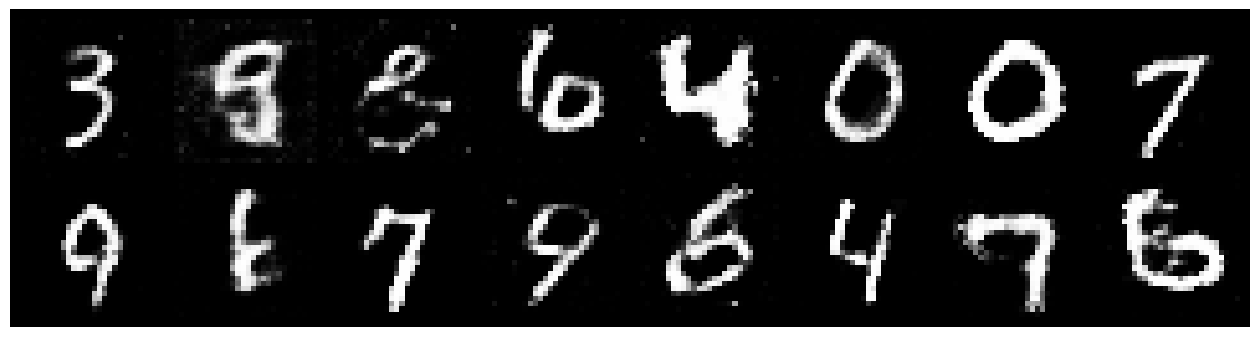

Epoch: [199/200], Batch Num: [500/600]
Discriminator Loss: 1.3389, Generator Loss: 0.8982
D(x): 0.5126, D(G(z)): 0.4360


In [11]:
logger = Logger(model_name='VGAN', data_name='MNIST')

for epoch in range(num_epochs):
    for n_batch, (real_batch,_) in enumerate(data_loader):

        # Train discriminator on a real batch and a fake batch
        
        real_data = images_to_vectors(real_batch)
        if torch.cuda.is_available(): real_data = real_data.cuda()
        fake_data = generator(noise(real_data.size(0))).detach()
        d_error, d_pred_real, d_pred_fake = train_discriminator(d_optimizer,
                                                                real_data, fake_data)
        
        # Train generator

        fake_data = generator(noise(real_batch.size(0)))
        g_error = train_generator(g_optimizer, fake_data)
        
        # Log errors and display progress

        logger.log(d_error, g_error, epoch, n_batch, num_batches)
        if (n_batch) % 100 == 0:
            display.clear_output(True)
            # Display Images
            test_images = vectors_to_images(generator(test_noise)).data.cpu()
            logger.log_images(test_images, num_test_samples, epoch, n_batch, num_batches);
            # Display status Logs
            logger.display_status(
                epoch, num_epochs, n_batch, num_batches,
                d_error, g_error, d_pred_real, d_pred_fake
            )
            
        # Save model checkpoints
        logger.save_models(generator, discriminator, epoch)

### 1.1.9 Plot

In [12]:
%matplotlib inline  
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
img = mpimg.imread('tensorboard_plot/VGAN_MNIST.jpg')
plt.figure(figsize=(20,5))
plt.imshow(img)

## 1.2 DCGAN for CIFAR

The DCGAN is a GAN with a generator
designed to do just that, generate larger RGB images using convolutional layers.


### 1.2.1 Load CIFAR dataset

In [22]:
import torch
from torch import nn, optim
from torchvision import transforms, datasets

DATA_FOLDER = './torch_data/DCGAN/CIFAR'
def cifar_data():
    compose = transforms.Compose(
        [transforms.Resize(64),
            transforms.ToTensor(),
            transforms.Normalize((.5, .5, .5), (.5, .5, .5))
        ])
    out_dir = '{}/dataset'.format(DATA_FOLDER)
    return datasets.CIFAR10(root=out_dir, train=True, transform=compose, download=True)

# Load Dataset and attach a DataLoader

data = cifar_data()
batch_size = 100
data_loader = torch.utils.data.DataLoader(data, batch_size=batch_size, shuffle=True)
num_batches = len(data_loader)
num_batches

Files already downloaded and verified


500

#### 1.2.2 Discriminator

Here are PyTorch Modules for them:

In [23]:
#NO BIASES BECAUSE BATCHNORM!!!
class DiscriminativeNet(torch.nn.Module):
    
    def __init__(self):
        super(DiscriminativeNet, self).__init__()
        
        self.conv1 = nn.Sequential(
            nn.Conv2d(
                in_channels=3, out_channels=128, kernel_size=4, 
                stride=2, padding=1, bias=False
            ),
            nn.LeakyReLU(0.2, inplace=True)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(
                in_channels=128, out_channels=256, kernel_size=4,
                stride=2, padding=1, bias=False  
            ),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True)
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(
                in_channels=256, out_channels=512, kernel_size=4,
                stride=2, padding=1, bias=False
            ),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True)
        )
        self.conv4 = nn.Sequential(
            nn.Conv2d(
                in_channels=512, out_channels=1024, kernel_size=4,
                stride=2, padding=1, bias=False
            ),
            nn.BatchNorm2d(1024),
            nn.LeakyReLU(0.2, inplace=True)
        )
        self.out = nn.Sequential(
            nn.Linear(1024*4*4, 1), # #filters,height,width
            nn.Sigmoid(),
        )

    def forward(self, x):
        # Convolutional layers
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        # Flatten and apply sigmoid
        x = x.view(-1, 1024*4*4)
        x = self.out(x)
        return x

#### 1.2.3 Generator

The generator is using transpose convolutions with batch normalization:

In [24]:
class GenerativeNet(torch.nn.Module):
    
    def __init__(self):
        super(GenerativeNet, self).__init__()
        
        self.linear = torch.nn.Linear(100, 1024*4*4)
        
        self.conv1 = nn.Sequential(
            nn.ConvTranspose2d(
                in_channels=1024, out_channels=512, kernel_size=4,
                stride=2, padding=1, bias=False
            ),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True)
        )
        self.conv2 = nn.Sequential(
            nn.ConvTranspose2d(
                in_channels=512, out_channels=256, kernel_size=4,
                stride=2, padding=1, bias=False
            ),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True)
        )
        self.conv3 = nn.Sequential(
            nn.ConvTranspose2d(
                in_channels=256, out_channels=128, kernel_size=4,
                stride=2, padding=1, bias=False
            ),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True)
        )
        self.conv4 = nn.Sequential(
            nn.ConvTranspose2d(
                in_channels=128, out_channels=3, kernel_size=4,
                stride=2, padding=1, bias=False
            )
        )
        self.out = torch.nn.Tanh()
    '''
    "The ReLU activation (Nair & Hinton, 2010) is used in the generator 
    with the exception of the output layer which uses the Tanh function. 
    We observed that using a bounded activation allowed the model to learn 
    more quickly to saturate and cover the color space of the training distribution. 
    Within the discriminator we found the leaky rectified activation 
    (Maas et al., 2013) (Xu et al., 2015)to work well, especially for higher resolution modeling. 
    This is in contrast to the original GAN paper, 
    which used the maxout activation (Goodfellow et al., 2013)."
    '''
    def forward(self, x):
        # Project and reshape
        x = self.linear(x)
        x = x.view(x.shape[0], 1024, 4, 4)
        # Convolutional layers
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        # Apply Tanh
        return self.out(x)

# Function to create noise samples for the generator's input

def noise(size):
    n = torch.randn(size, 100)
    if torch.cuda.is_available(): return n.cuda() 
    return n

#### 1.2.4 Initialize weights
Let's create a generator and discriminator and initialize their weights: 

In [25]:
# Custom weight initialization

def init_weights(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1 or classname.find('BatchNorm') != -1:
        m.weight.data.normal_(0.00, 0.02)

# Instantiate networks

generator = GenerativeNet()
generator.apply(init_weights)
discriminator = DiscriminativeNet()
discriminator.apply(init_weights)

# Enable cuda if available

if torch.cuda.is_available():
    generator.cuda()
    discriminator.cuda()

#### 1.2.5 Optimizers

Next, we set up the optimizers and loss function.

In [26]:
# Optimizers

d_optimizer = optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))
g_optimizer = optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))

# Loss function
loss = nn.BCELoss()

# Number of epochs of training
num_epochs = 30

#### 1.2.6 Training

As before, we'll generate a fixed set of noise samples to see the evolution of the
generator over time then start training:

In [31]:
def real_data_target(size):
    '''
    Tensor containing ones, with shape = size
    '''
    data = torch.ones(size, 1)
    if torch.cuda.is_available(): return data.cuda()
    return data

def fake_data_target(size):
    '''
    Tensor containing zeros, with shape = size
    '''
    data = torch.zeros(size, 1)
    if torch.cuda.is_available(): return data.cuda()
    return data

In [28]:
def train_discriminator(optimizer, real_data, fake_data):
    # Reset gradients
    optimizer.zero_grad()
    
    # Propagate real data
    prediction_real = discriminator(real_data)
    error_real = loss(prediction_real, real_data_target(real_data.size(0)))
    error_real.backward()

    # Propagate fake data
    prediction_fake = discriminator(fake_data)
    error_fake = loss(prediction_fake, fake_data_target(real_data.size(0)))
    error_fake.backward()
    
    # Take a step
    optimizer.step()
    
    # Return error
    return error_real + error_fake, prediction_real, prediction_fake

In [29]:
def train_generator(optimizer, fake_data):
    # Reset gradients
    optimizer.zero_grad()

    # Propagate the fake data through the discriminator and backpropagate.
    # Note that since we want the generator to output something that gets
    # the discriminator to output a 1, we use the real data target here.
    prediction = discriminator(fake_data)
    error = loss(prediction, real_data_target(prediction.size(0)))
    error.backward()
    
    # Update weights with gradients
    optimizer.step()
    
    # Return error
    return error

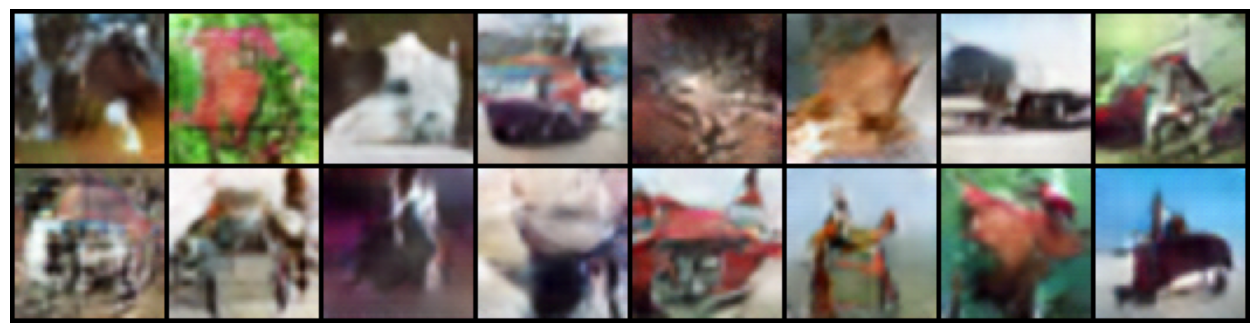

Epoch: [29/30], Batch Num: [400/500]
Discriminator Loss: 0.1189, Generator Loss: 3.5956
D(x): 0.9392, D(G(z)): 0.0515


In [32]:
num_test_samples = 16
test_noise = noise(num_test_samples)

logger = Logger(model_name='DCGAN', data_name='CIFAR10')

for epoch in range(num_epochs):
    for n_batch, (real_data,_) in enumerate(data_loader):

        # Train Discriminator
        
        #if torch.cuda.is_available(): real_data = real_data.cuda(device)
        if torch.cuda.is_available(): real_data = real_data.cuda()
        fake_data = generator(noise(real_data.size(0))).detach()
        d_error, d_pred_real, d_pred_fake = train_discriminator(d_optimizer, 
                                                                real_data, fake_data)

        # Train Generator
        
        fake_data = generator(noise(real_data.size(0)))
        g_error = train_generator(g_optimizer, fake_data)

        # Log error and display progress
        logger.log(d_error, g_error, epoch, n_batch, num_batches)
        if (n_batch) % 100 == 0:
            display.clear_output(True)
            # Display Images
            test_images = generator(test_noise).data.cpu()
            logger.log_images(test_images, num_test_samples, epoch, n_batch, num_batches);
            # Display status Logs
            logger.display_status(
                epoch, num_epochs, n_batch, num_batches,
                d_error, g_error, d_pred_real, d_pred_fake
            )

        # Save model checkpoints
        logger.save_models(generator, discriminator, epoch)

#### 1.2.7 Plot

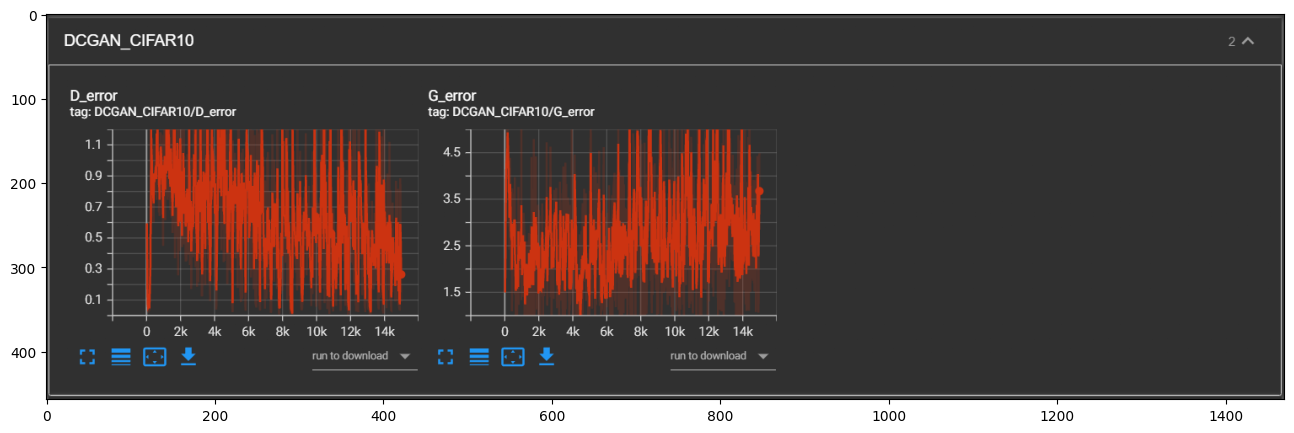

In [35]:
%matplotlib inline  
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
img = mpimg.imread('tensorboard_plot/DCGAN_FICAR10.png')
plt.figure(figsize=(20,5))
plt.imshow(img)

#### Evaluation on MINIST

The training of MNIST dataset on VGAN produces a positive results at 200th epoch. As shown in the plots, it can be seen that both losses start to converge. Moreover, D(x) also starts to get closer to 0.5, this indicates that the performance of the discriminator is also at its optimal.

#### Evaluation on CIFAR

Simuilar to the training of MNIST dataset, the training CIFAR also shows somewhat positive results. D(x) also starts to get closer to 0.5 and the losses start to converge. One thing to notice is that the losses of MNIST are less fluctuating than those of CIFAR.